# Explainable ML: A peek into the black box through SHAP

The insurance industry has always been more conservative when it comes to modelling, and with good reason. The financial and social impact of a wrongly predicted say, fraud detection model denying a policyholder’s entitlement to a claim is huge, compared to a wrongly predicted song recommendation pushed from your favourite music player’s machine learning algorithm. 

As actuaries doing technical modelling for insurance premiums, some common “workarounds” would be to stick with our favourite GLMs since it is a lot more transparent, or map/tag your GBM results to that of a GLM in some way, just to get some comfort and clarity regarding what the model is doing globally.

In this article, we will introduce (at a high level) the underlying concept of SHAP, as well as work through the python implementation using a sample insurance claims dataset.

## Run this from your browser

The python code shown this snippet can be run from your browser through this link.

Note that some loading time is to be expected, particularly when performing gridsearch and cross-validation for the machine learning models. However, the binder does not require the reader to download the dataset, or any other dependencies to run the models. Furthermore, the reader is encouraged to play around with the code and look at how SHAP explains the different predictions.

## Tools and Packages

The example uses [Python3](https://www.python.org/downloads/release/python-379/) and the main packages that we will be using are listed below:

- [Shap](https://pypi.org/project/shap/) for model validation
- [Matplotlib](https://pypi.org/project/matplotlib/) for visualisation as shap graphs uses it as a backend
- [Pandas](https://pypi.org/project/pandas/) for general data manipulation
- [Sci-kit learn's](https://pypi.org/project/scikit-learn/) pipeline framework

Note that the sklearn pipeline is the main backbone of the process here out of convenience but any other framework would work just as well.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import shap
import warnings

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import GradientBoostingRegressor

warnings.filterwarnings('ignore')
plt.ioff()

## Importing, Preprocessing, Modelling

The dataset used in the article includes some policyholder information as follows: 

- **age**: Policyholder age (integer)
- **sex**: Gender of the policyholder (female=0, male=1)
- **bmi**: Body mass index (float)
- **children**: Number of children/ dependents of policyholder (integer)
- **smoker**: Smoking state of policyholder (non-smoker=0, smoker=1)
- **region**: Residential area of the policyholder in the US (string)

As well as a claims cost response column. The data can be downloaded from the github repository [here](https://github.com/sharmaroshan/Insurance-Claim-Prediction).


Note that although all the usual steps in the modelling process are involved here, this article will mainly focus on using the SHAP package and interpreting the results. With that in mind, the rest of this section will not be covered in detail, but includes:
- Importing the data
- Splitting the dataset into training and testing sets
- Creating a "preprocesser" step to one-hot-encode categorical features
- Building a sklearn pipeline with the preprocessing and a GBM Regressor model
- Performing gridsearch and cross-validation for the GBM model to get the "best" set of hyperparameters


#### Importing

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/sharmaroshan/Insurance-Claim-Prediction/master/insurance.csv")

rating_factors_col = list(df.columns[:-1])
claims_col = df.columns[-1]

In [3]:
num_features = list(df[rating_factors_col].select_dtypes(include=["int64", "float64"]).columns)
cat_features = [col for col in rating_factors_col if col not in num_features]

#### Preprocessing

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
            df[rating_factors_col],
            df[claims_col],
            test_size=0.2,
            random_state=123
        )

In [5]:
preprocesser = ColumnTransformer(
    transformers = [
        ("numerical", "passthrough", num_features),
        ("categorical", OneHotEncoder(sparse=False, handle_unknown="ignore"), cat_features)
    ]
)

In [6]:
ohe_categories = preprocesser.fit(X_train).named_transformers_["categorical"].categories_
ohe_categories_concat = [f"{col}__{val}" for col, vals in zip(cat_features, ohe_categories) for val in vals]
rating_factors_encoded = num_features + ohe_categories_concat

In [7]:
param_grid = {
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__max_depth": [2, 3, 5],
    "model__max_features": [2, 3, 5, 7],
    "model__min_samples_leaf": [3, 4, 5],
    "model__min_samples_split": [2, 3, 5],
    "model__n_estimators": [100, 300, 500]
}

gbm_model = Pipeline([("preprocesser", preprocesser), ("model", GradientBoostingRegressor())])

#### Modelling: Gradient Boosted Machine

In [8]:
gs = GridSearchCV(
    gbm_model, 
    param_grid=param_grid, 
    n_jobs=-1, 
    cv=5, 
    scoring="neg_root_mean_squared_error"
)

In [9]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocesser',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         'passthrough',
                                                                         ['age',
                                                                          'bmi',
                                                                          'children']),
                                                                        ('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['sex',
                                                                          'smoker',
                                  

In [10]:
gbm_model.set_params(**gs.best_params_)
gbm_model.fit(X_train, y_train)
gbm_pred = gbm_model.predict(X_test)

## Model Validation

#### What is SHAP?

SHAP stands for Shapley Additive Explanations and uses a game theory approach (Shapley Values) applied on machine learning to "fairly allocate contributions" to the model features for a given output. The underlying process of getting SHAP values for a particular feature $f$ out of the set $F$ can be summarized as follows:

- Get the [Power Set](https://en.wikipedia.org/wiki/Power_set) of $F$, which  contains $2^{F}$ combinations of features
- Run the model for all combinations in the set
- Record the marginal contributions to the model output for $f$
- Calculated a weighted sum of $f$'s marginal contributions to get the SHAP value of feature $f$ for a given output. Or in other words, $f$'s contribution to the model output

For more details, there are various resources in the appendix for the reader to delve deeper into this concept, including the original white paper.

#### SHAP package in Python

The SHAP python framework provides a variety of visualisations for model validation and can be found [here](https://shap.readthedocs.io/en/latest/api.html). However, for our purposes, we will only be concentrating on the Partial Dependency Plot (PDP) and the SHAP Waterfall Plot.

We will also look at the results in the context of a particular observation with index=30.

In [12]:
idx = 30
feature = "bmi"

shap_df = pd.DataFrame(gbm_model.named_steps["preprocesser"].transform(X_train), columns=rating_factors_encoded)

Similar to the LIME package, SHAP works with explainer objects to calculate the results, and because we have opted to use a GBM regressor for this example, we will be using the TreeExplainer object.

In [14]:
gbm_explainer = shap.TreeExplainer(gbm_model.named_steps["model"])
gbm_shap_values = gbm_explainer(shap_df)

# This line below is a quick workaround to get pass an assert condition in the SHAP 
# waterfall function. Can be ignored
gbm_shap_values.base_values = gbm_shap_values.base_values[:, 0]

#### Waterfall Plots (Local)

The SHAP waterfall plots aims to explain how individual claim predictions come about.

1. On the Y-axis, we have our encoded features, with the values observed for idx=30
2. On the X-axis, we have the range of our response (claims costs) in dollars
3. Note that $E[f(X)]=\$13,189.258$ is the result from the null model, or the global average claims cost from our dataset
4. Also note that $f(x)=\$14,959.311$ is the model prediction for values observed in (1)

So, we can see from the plot below that this policyholder’s expected claims cost is ~13% higher than the average, and both the gender and region did not contribute materially to this outcome. While the higher-than-average BMI did contribute to ~$1.3k more to the costs, this was mostly offset by the fact that she had no children.

The 2 main drivers mostly offset each other as well, but the fact that she is aged outweighed the effect of being a non-smoker by ~$1.4k, which makes up the bulk of the net increase from the average.

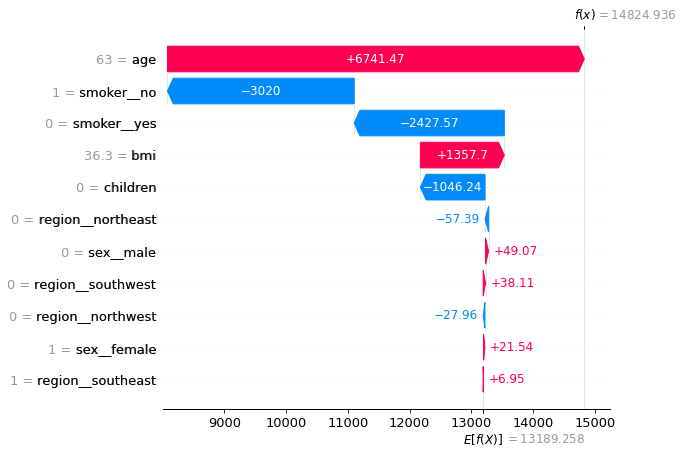

In [15]:
shap.plots.waterfall(gbm_shap_values[idx], max_display=14, show=False)
plt.show()

#### Force plots ("Global")

The force plots in the SHAP package can output both local and "global" interpretation graphs, but in this example, we have inputted the whole array of SHAP values and data points into the function, to get a model-level view of the results. 

While both axes can be customized from the combo box, by default, the Y-axis shows the output value of the model, while the X-axis plots all the samples in the dataset sorted by similarity (I personally like sorting it by output value). By hovering over an area of the graph, we can get a quick summary of the significant rating factors that are driving the modelled costs up (in red) or down (in blue). 

Just at a high level we can observe that the model has put a lot of emphasis on the state of smoking and age, which is in line with high BMIs have an interaction effect with smoking, accounting for many of the higher claim predictions.

In [16]:
shap.initjs()
shap.force_plot(gbm_explainer.expected_value[0], gbm_shap_values.values, shap_df)

#### SHAP Dependency plots ("Global")

The SHAP dependency plot is a very simple graph that shows how the SHAP contributions differ for different values of the feature (BMI in this case). This is like a PDP, except that PDPs show average effects while the SHAP dependency plots show the variance on the y-axis. Here, we can clearly see an interaction effect between BMI values and the smoking state of the policyholder.

We see that the pink data points (non-smokers) have a more gradual slope for BMI contributions in contrast to the blue points (smokers), where the SHAP contributions jump significantly at the BMI=~30 point, which is in line with what we could guess from the previous force plot output above.

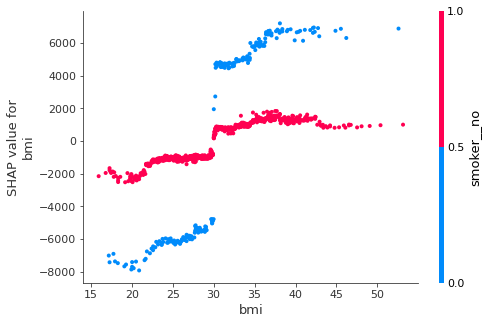

In [17]:
shap.dependence_plot(feature, gbm_shap_values.values, shap_df)

## SHAP vs LIME?

Now that we've seen some of the functionality available to us in the Python SHAP framework (available in R as well), it only makes sense to compare its advantages and disadvantages to another popular framework like LIME, which also utilizes the idea of explanation model for local interpretation using some form of linear approximation. Note that this list is non-exhaustive and only includes the most obvious/popular ones.

**Advantages**:
- SHAP provides a complete explanation between the global average and the model output for a particular explanation, whereas LIME's model may not, depending on the fit of the localized linear regression, this means that SHAP is more legally/professionally compliant than other methods.
- SHAP values are fairly distributed among the features whereas LIME does not guarantee this.
- SHAP has the backing of a long-standing and well understood economic theory. The underlying axioms and properties give SHAP a good foundation of why it should work, whereas LIME relies on the assumption of linearity locally.

**Disadvantages**:
- Only approximate solutions are feasible most of the time, the power set of models to compute exact solutions are very computationally expensive. Just imagine computing $2^{20}$ GBM models on a small-sized dataset.

- SHAP values can easily be misinterpreted. By removing the feature for a particular observation, we do not get an outcome of the prediction less the SHAP value of that feature.  This also means that SHAP values cannot make predictions for changes in the input whereas results from LIME allows statements like: "_If this policyholder's BMI increased by 1, we can expect the modelled claims cost to increase by ~$500._"

## Afterward

As data becomes increasingly available and insurance products continue to get more complex, the use of more robust models to handles these interactions will be inevitable for many prediction tasks across the whole insurance value chain, not just for claims modelling and fraud detection.

Validation frameworks like SHAP and LIME seem to be a big step in the direction of model-agnostic-additive explanations. While article gives the reader a gentle and practical introduction to the idea and implementation behind SHAP, note that the theory and mathematics are a little more involved. If you are interested in deep diving into the details, there are a few links below to get you started.


- [A Unified Approach to Interpreting Model Predictions](https://arxiv.org/abs/1705.07874)
- [Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/)
- [SHAP framework Github Repository](https://github.com/slundberg/shap)